In [ ]:
import os
import mne
import pyxdf
import numpy as np
%matplotlib qt
import matplotlib.pyplot as plt
matplotlib.style.use('default')

In [ ]:
labels = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10',
          'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10']
x_coords = [-72, -81, -99, -108, -109, -109, -108, -99, -81, -72,
            72, 81, 99, 108, 109, 109, 108, 99, 81, 72]
y_coords = [0.67778, 0.73333, 0.73333, 0.67778, 0.63889, 0.60556, 0.56667, 0.51111, 0.51111, 0.56667,
            0.67778, 0.73333, 0.73333, 0.67778, 0.63889, 0.60556, 0.56667, 0.51111, 0.51111, 0.56667]
lpa_x = (x_coords[0] + x_coords[9])/2
lpa_y = (y_coords[0] + y_coords[9])/2

rpa_x = (x_coords[10] + x_coords[19])/2
rpa_y = (y_coords[10] + y_coords[19])/2

naison_x = (x_coords[2] + x_coords[11]+9)/2
naison_y = (y_coords[2] + y_coords[11])/2
print("Naison coordinates: ", naison_x, naison_y)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_coords, y_coords, c='blue', marker='o')
plt.scatter(lpa_x, lpa_y, c='red', marker='x', label='LPA')
plt.scatter(rpa_x, rpa_y, c='green', marker='x', label='RPA')
plt.scatter(naison_x, naison_y, c='purple', marker='^', label='Nasion')
plt.annotate('LPA', xy=(lpa_x, lpa_y), xytext=(0, 5),
             textcoords="offset points",
             fontsize=8, ha='center')
plt.annotate('RPA', xy=(rpa_x, rpa_y), xytext=(0, 5),
                textcoords="offset points",
                fontsize=8, ha='center')
plt.annotate('Nasion', xy=(naison_x, naison_y), xytext=(0, 5),
                textcoords="offset points",
                fontsize=8, ha='center')

# Adding labels to each point
for i, label in enumerate(labels):
    plt.annotate(label,  # The text to display
                 (x_coords[i], y_coords[i]),  # The position to place the text
                 textcoords="offset points",  # How to position the text
                 xytext=(0, 5),  # Offset text by 5 points above
                 ha='center',  # Horizontal alignment
                 fontsize=8)  # Font size

# Adding a legend, title and axes labels
plt.legend()
plt.title('Electrode Positions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Labels
labels = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10',
          'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10']

# 2D electrode positions
x_coords = np.array([-72, -81, -99, -108, -109, -109, -108, -99, -81, -72,
                     72, 81, 99, 108, 109, 109, 108, 99, 81, 72])
y_coords = np.array([0.67778, 0.73333, 0.73333, 0.67778, 0.63889, 0.60556, 0.56667, 0.51111, 0.51111, 0.56667,
                     0.67778, 0.73333, 0.73333, 0.67778, 0.63889, 0.60556, 0.56667, 0.51111, 0.51111, 0.56667])
elec_2d = np.column_stack([x_coords, y_coords])

# Real 3D fiducials (in meters)
lpa_3d = np.array([-0.08061612, -0.02908875, -0.04131077])
rpa_3d = np.array([0.08436285, -0.02850276, -0.04127743])
nasion_3d = np.array([0.00146763,  0.08506715, -0.03483611])
tgt_fids = np.vstack([lpa_3d, rpa_3d, nasion_3d])

# Known physical distance between L1 and L10 is 4 cm
l1_2d = elec_2d[0]
l10_2d = elec_2d[9]
euclidean_dist = np.linalg.norm(l1_2d - l10_2d)
real_world_dist = 0.04  # meters
scale = real_world_dist / euclidean_dist
elec_2d_scaled = elec_2d * scale  # Now in meters

# Compute fiducials in scaled space
lpa_2d = np.mean([elec_2d_scaled[0], elec_2d_scaled[9]], axis=0)
rpa_2d = np.mean([elec_2d_scaled[10], elec_2d_scaled[19]], axis=0)
nasion_2d = np.mean([elec_2d_scaled[2], elec_2d_scaled[12]], axis=0)
src_fids = np.vstack([lpa_2d, rpa_2d, nasion_2d])

# Fit 2D → 3D affine transform
reg = LinearRegression()
reg.fit(src_fids, tgt_fids)
A = reg.coef_
b = reg.intercept_
elec_3d = elec_2d_scaled @ A.T + b

# Plot the 3D electrode positions
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(elec_3d[:, 0], elec_3d[:, 1], elec_3d[:, 2], c='b')

for i, label in enumerate(labels):
    ax.text(elec_3d[i, 0], elec_3d[i, 1], elec_3d[i, 2], label)

ax.set_title("Transformed Electrode Positions (3D)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
plt.tight_layout()
plt.show()


In [23]:
import mne

# Create montage from transformed 3D electrode positions
ch_pos = dict(zip(labels, elec_3d))
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')

# Create a fake info object
info = mne.create_info(ch_names=labels, sfreq=1000., ch_types='eeg')
info.set_montage(montage)

# Plot in 2D
fig_2d = info.plot_sensors(kind='topomap', show_names=True)

# Plot in 3D
# fig_3d = mne.viz.plot_alignment(info, dig=True, show_axes=True)

# (fig_2d, fig_3d)


In [ ]:
montages = mne.channels.get_builtin_montages(descriptions=True)
easycap_montage = mne.channels.make_standard_montage(montages[1][0])
print(easycap_montage)
easycap_montage.get_positions()

# easycap_montage.plot(kind="topomap")

In [18]:
def closest_points_vector(eeg_timestamps, marker_timestamps):
    # Get the insertion indices for each marker timestamp
    indices = np.searchsorted(eeg_timestamps, marker_timestamps)

    # Preallocate the output array as a copy of indices.
    closest_eeg_indices = indices.copy()

    # Create a mask for markers where the insertion index equals 0 (marker before first EEG timestamp)
    mask_begin = (indices == 0)
    # For these, the closest EEG index is 0 (they cannot use a previous value)
    closest_eeg_indices[mask_begin] = 0

    # Create a mask for markers where the insertion index equals the length of the EEG timestamps
    mask_end = (indices == len(eeg_timestamps))
    # For these markers, set the closest EEG index to the last index
    closest_eeg_indices[mask_end] = len(eeg_timestamps) - 1

    # Create a mask for the "middle" markers, i.e., not at the very beginning or end
    mask_middle = (indices > 0) & (indices < len(eeg_timestamps))

    # For markers in the middle, compute the distance to the previous and next EEG timestamps:
    prev_times = eeg_timestamps[indices[mask_middle] - 1]
    next_times = eeg_timestamps[indices[mask_middle]]
    marker_times_middle = marker_timestamps[mask_middle]

    # Calculate the differences
    diff_prev = marker_times_middle - prev_times
    diff_next = next_times - marker_times_middle

    # For each marker in the middle, choose the index of the EEG timestamp that is closer:
    # If the distance to the previous timestamp is less or equal than the distance to the next,
    # then we pick indices[mask_middle]-1; otherwise, we pick indices[mask_middle].
    closest_eeg_indices[mask_middle] = np.where(diff_prev <= diff_next,
                                                indices[mask_middle] - 1,
                                                indices[mask_middle])

    return closest_eeg_indices

def create_mappings(event_names, prefix):
    marker_dict = {p: i for i, p in enumerate(
        np.unique(event_names))}
    id_binding = {v: k for k, v in marker_dict.items()}
    category_mapping = {
        p: {k: v for k, v in marker_dict.items() if k.startswith(p)} for p in prefix
    }
    return marker_dict, id_binding, category_mapping

def create_events(time_points, event_mapping, event_names):
    label_id_func = np.vectorize(event_mapping.get)
    events = np.zeros((len(time_points), 3), dtype=int)
    events[:, 0] = time_points
    events[:, 2] = label_id_func(event_names)
    return events

## EEG Observations
Missing EEG: 129059



In [19]:
subs = [797337,129059, 617834, 822866, 991031]
EXP_ROOT = "exp_data"
INPUT_ROOT = "input"
OUTPUT_ROOT = "output"
sub_id = 797337
DATA_FILE = os.path.join(
    EXP_ROOT, f"sub-{sub_id}", f"sub-{sub_id}_task-hearing_run-001.xdf")
RAW_VIDEO = os.path.join(INPUT_ROOT, f"{sub_id}.avi")
# DATA_FILE = os.path.join(EXP_ROOT,"elizabeth.xdf")
data, header = pyxdf.load_xdf(DATA_FILE)
print([stream['info']['type'][0] for stream in data])

Stream 4: Calculated effective sampling rate 0.0000 Hz is different from specified rate 50.0000 Hz.


['Markers', 'PPG', 'Video', 'EEG', 'EEG']


In [30]:
marker_stream = next(
    stream for stream in data if stream['info']['type'][0] == 'Markers')
# video_stream = next(
#     stream for stream in data if stream['info']['type'][0] == 'Video')
# ppg_stream = next(
#     stream for stream in data if stream['info']['type'][0] == 'PPG')
# eeg_stream = next(
#     stream for stream in data if stream['info']['type'][0] == 'EEG')
eeg_stream = data[4]

In [32]:
marker_timestamps = marker_stream['time_stamps']
marker_data = np.array(marker_stream['time_series']).squeeze()
eeg_data = eeg_stream['time_series'] * 1e-6  # convert to volts
eeg_timestamps = eeg_stream['time_stamps']
eeg_insert_points = closest_points_vector(eeg_timestamps, marker_timestamps)

In [33]:
bindings = ['pmt','hlt','let','ast']
marker_dict, id_binding, category_mapping = create_mappings(marker_data, bindings)
events = create_events(eeg_insert_points, marker_dict, marker_data)

Creating RawArray with float64 data, n_channels=16, n_times=170520
    Range : 0 ... 170519 =      0.000 ...  1364.152 secs
Ready.
Finding segments below or above PTP threshold.
Bad channels: ['R7']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 825 samples (6.600 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method

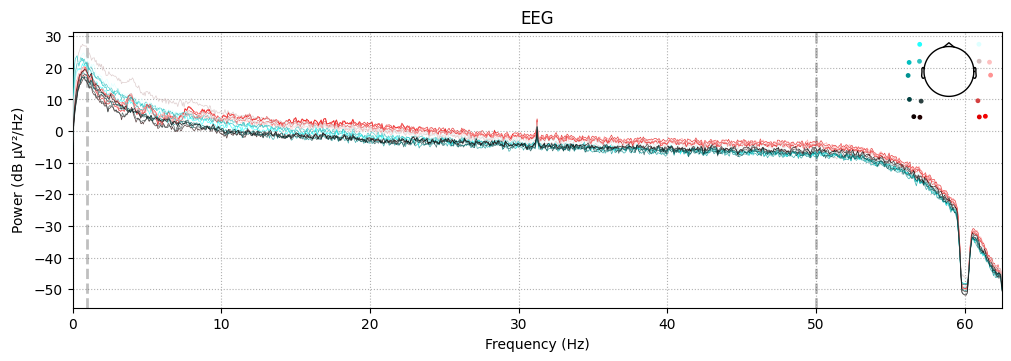

In [36]:
ch_labels = ['L1', 'L2', 'L4', 'L5', 'L7', 'L8', 'L9', 'L10',
             'R1', 'R2', 'R4', 'R5', 'R7', 'R8', 'R9', 'R10']
# ch_labels = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1',
#              'O2', 'F7', 'F8', 'F3', 'F4', 'T7', 'T8', 'P3', 'P4']
sampling_rate = 125

eeg_data = eeg_stream['time_series'].T * 1e-6
info = mne.create_info(
    ch_names=ch_labels, sfreq=sampling_rate, ch_types='eeg')
raw = mne.io.RawArray(eeg_data, info)
# raw.filter(l_freq=1, h_freq=None)

flalt_voltage = 0.1
_, bads = mne.preprocessing.annotate_amplitude(
    raw, flat=dict(eeg=flalt_voltage*1e-6))
raw.info['bads'] = bads
print(f"Bad channels: {bads}")
# raw.interpolate_bads()
annot = mne.annotations_from_events(
    events, raw.info['sfreq'], id_binding)
raw.set_annotations(annot)

raw.set_montage(montage)  # Set the montage to the raw object   
# raw.plot_psd(fmax=62)

raw = raw.notch_filter(60)
bandpass = {'low': 1, 'high': 50}
raw = raw.filter(l_freq=bandpass['low'], h_freq=bandpass['high'])

raw.plot_psd()
# raw.plot_psd(fmax=62,dB=True)

In [38]:
epoch = mne.Epochs(raw, events, tmin=-0.3, tmax=5)
epoch

Not setting metadata
302 matching events found
Setting baseline interval to [-0.304, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


<Epochs | 302 events (good & bad), -0.304 – 5 s (baseline -0.304 – 0 s), ~24 KiB, data not loaded,
 '0': 5
 '1': 5
 '2': 5
 '3': 5
 '4': 5
 '5': 5
 '6': 30
 '7': 5
 '8': 5
 '9': 5
 and 123 more events ...>